In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Make a list of calibration images
objpoints=[]
imgpoints=[]
images=glob.glob('C://Users//Shivam.Chawla01//CarND-Advanced-Lane-Lines//camera_cal//calibration*.jpg')
for fname in images:
    img=mpimg.imread(fname)
    plt.imshow(img)
    
    

    objp=np.zeros((9*6,3),np.float32)
    objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)

    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if(ret==True):
        imgpoints.append(corners)
        objpoints.append(objp)
    
        img=cv2.drawChessboardCorners(img,(9,6),corners,ret)
        plt.imshow(img)





In [2]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if(orient=='x'):
        sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0)
        abs_sobel=np.absolute(sobelx)
    elif(orient=='y'):
        sobely=cv2.Sobel(gray,cv2.CV_64F,0,1)
        abs_sobel=np.absolute(sobely)
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    sxbinary=np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])]=1
    grad_binary=sxbinary
    return grad_binary

In [3]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobel_x=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobel_y=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_Sobel_x=np.absolute(sobel_x)
    abs_Sobel_y=np.absolute(sobel_y)
    grad_drtn=np.arctan2(abs_Sobel_y,abs_Sobel_x)
    binary_output=np.zeros_like(grad_drtn)
    binary_output[(grad_drtn>=thresh[0]) & (grad_drtn<=thresh[1])]=1
    return binary_output

In [4]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x=cv2.Sobel(gray,cv2.CV_64F,1,0)
    sobel_y=cv2.Sobel(gray,cv2.CV_64F,0,1)
    # 3) Calculate the magnitude
    mag_sobel=np.sqrt(sobel_x**2+sobel_y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel=np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary=np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>=mag_thresh[0]) & (scaled_sobel<=mag_thresh[1])]=1
    mag_binary=sxbinary
    return mag_binary
    

In [5]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S=hls[:,:,2]
    binary_output=np.zeros_like(S)
    # 3) Return a binary image of threshold result
    binary_output[(S>thresh[0]) & (S<=thresh[1])]=1
    #binary_output = np.copy(img) # placeholder line
    return binary_output

In [6]:

def cal_undistort(img, objpoints, imgpoints):
        # Use cv2.calibrateCamera() and cv2.undistort()
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        udst=cv2.undistort(img,mtx,dist,None,mtx)
        #undist = np.copy(img)  # Delete this line
        return udst


In [9]:
def pipeline(img):
    undistorted = cal_undistort(img, objpoints, imgpoints)
    img_size=(img.shape[1],img.shape[0])
    hls_threshold=hls_select(undistorted, (170, 255))
    gradx = abs_sobel_thresh(undistorted, orient='x', thresh=(50, 100))
    mag_threshold=mag_thresh(undistorted,3,(90, 255))
    dir_thresh=dir_threshold(undistorted,3,(0.7, 1.3))
    combined_binary = np.zeros_like(gradx)
    combined_binary[(hls_threshold == 1) | (gradx == 1) | (mag_threshold==1) | (dir_threshold==1)] = 1
    ksize=3
    src=np.float32([[526,503],[801,503],[884,549],[461,549]])
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst=np.float32([[200,300],[900,300],[900,500],[200,500]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M=cv2.getPerspectiveTransform(src,dst)
    warped=cv2.warpPerspective(combined_binary ,M,img_size,flags=cv2.INTER_LINEAR)
    combined=np.dstack((warped,warped,warped))*255
    warped_gray=cv2.cvtColor(combined,cv2.COLOR_RGB2GRAY)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
    histogram = np.sum(warped_gray[warped_gray.shape[0]//2:,:], axis=0)
# plt.plot(histogram)
# Create an output image to draw on and  visualize the result
#out_img = np.dstack((combined, combined, combined))*255
    out_img=combined
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
# Choose the number of sliding windows
    nwindows = 9
# Set height of windows
    window_height = np.int(combined.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
# Set the width of the windows +/- margin
    margin = 100
# Set minimum number of pixels found to recenter window
    minpix = 50
# Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

# Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = combined.shape[0] - (window+1)*window_height
        win_y_high = combined.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

    # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)

    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    nonzero = out_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
    ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    margin=((left_fitx+right_fitx)/2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_gray, warped_gray, warped_gray))*255
    window_img = np.zeros_like(out_img)
# Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
    #print(np.int_([left_line_pts]))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    M=cv2.getPerspectiveTransform(dst,src)
    warped_orig=cv2.warpPerspective(window_img ,M,img_size,flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(undistorted, 1, warped_orig, 0.3, 0)
    
    return result




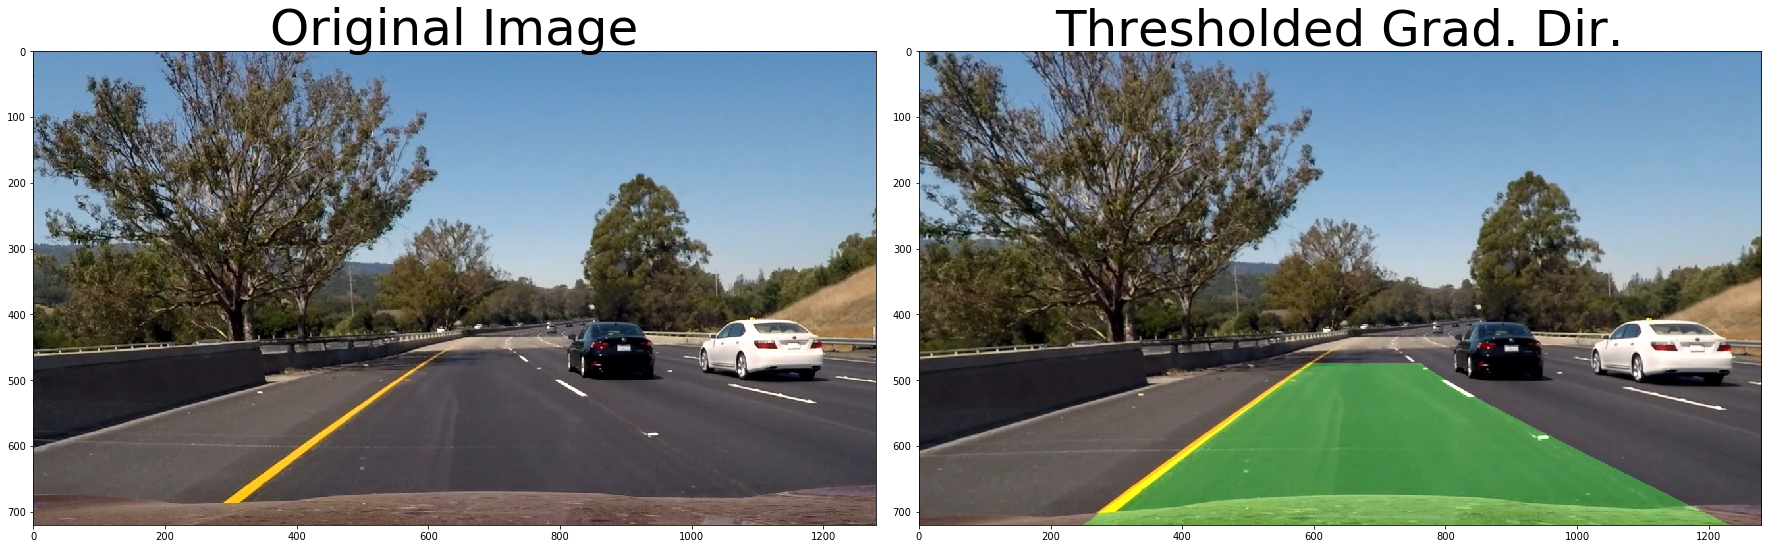

In [10]:
image = 'C://Users//Shivam.Chawla01//CarND-Advanced-Lane-Lines//test_images//test6.jpg'

img=mpimg.imread(image)
img_size=(img.shape[1],img.shape[0])

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image

#undistorted = cal_undistort(img, objpoints, imgpoints)

combined=pipeline(img)
# warped_gray=cv2.cvtColor(combined,cv2.COLOR_RGB2GRAY)

# # Assuming you have created a warped binary image called "binary_warped"
# # Take a histogram of the bottom half of the image
# histogram = np.sum(warped_gray[warped_gray.shape[0]//2:,:], axis=0)
# # plt.plot(histogram)
# # Create an output image to draw on and  visualize the result
# #out_img = np.dstack((combined, combined, combined))*255
# out_img=combined
# # Find the peak of the left and right halves of the histogram
# # These will be the starting point for the left and right lines
# midpoint = np.int(histogram.shape[0]//2)
# leftx_base = np.argmax(histogram[:midpoint])
# rightx_base = np.argmax(histogram[midpoint:])+midpoint
# # Choose the number of sliding windows
# nwindows = 9
# # Set height of windows
# window_height = np.int(combined.shape[0]//nwindows)
# # Identify the x and y positions of all nonzero pixels in the image
# nonzero = combined.nonzero()
# nonzeroy = np.array(nonzero[0])
# nonzerox = np.array(nonzero[1])
# # Current positions to be updated for each window
# leftx_current = leftx_base
# rightx_current = rightx_base
# # Set the width of the windows +/- margin
# margin = 100
# # Set minimum number of pixels found to recenter window
# minpix = 50
# # Create empty lists to receive left and right lane pixel indices
# left_lane_inds = []
# right_lane_inds = []

# # Step through the windows one by one
# for window in range(nwindows):
#     # Identify window boundaries in x and y (and right and left)
#     win_y_low = combined.shape[0] - (window+1)*window_height
#     win_y_high = combined.shape[0] - window*window_height
#     win_xleft_low = leftx_current - margin
#     win_xleft_high = leftx_current + margin
#     win_xright_low = rightx_current - margin
#     win_xright_high = rightx_current + margin
#     # Draw the windows on the visualization image
#     cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
#     (0,255,0), 2) 
#     cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
#     (0,255,0), 2) 
#     # Identify the nonzero pixels in x and y within the window
#     good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
#     (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
#     good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
#     (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
#     # Append these indices to the lists
#     left_lane_inds.append(good_left_inds)
#     right_lane_inds.append(good_right_inds)

#     # If you found > minpix pixels, recenter next window on their mean position
#     if len(good_left_inds) > minpix:
#         leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
#     if len(good_right_inds) > minpix:        
#         rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# # Concatenate the arrays of indices
# left_lane_inds = np.concatenate(left_lane_inds)
# right_lane_inds = np.concatenate(right_lane_inds)

# # Extract left and right line pixel positions
# leftx = nonzerox[left_lane_inds]
# lefty = nonzeroy[left_lane_inds] 
# rightx = nonzerox[right_lane_inds]
# righty = nonzeroy[right_lane_inds] 

# # Fit a second order polynomial to each
# left_fit = np.polyfit(lefty, leftx, 2)

# right_fit = np.polyfit(righty, rightx, 2)

# ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
# plt.imshow(out_img)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)



# plt.imshow(warped)
# histogram = np.sum(out_img[out_img.shape[0]//2:,:], axis=0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [11]:

# nonzeroy = np.array(nonzero[0])
# nonzerox = np.array(nonzero[1])
# margin = 100
# left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
# left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
# left_fit[1]*nonzeroy + left_fit[2] + margin))) 

# right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
# right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
# right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# # Again, extract left and right line pixel positions
# leftx = nonzerox[left_lane_inds]
# lefty = nonzeroy[left_lane_inds] 
# rightx = nonzerox[right_lane_inds]
# righty = nonzeroy[right_lane_inds]
# # Fit a second order polynomial to each
# left_fit = np.polyfit(lefty, leftx, 2)
# right_fit = np.polyfit(righty, rightx, 2)
# # Generate x and y values for plotting
# ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# # Create an image to draw on and an image to show the selection window
# out_img = np.dstack((combined_gray, combined_gray, combined_gray))*255
# window_img = np.zeros_like(out_img)
# # Color in left and right line pixels
# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# # Generate a polygon to illustrate the search window area
# # And recast the x and y points into usable format for cv2.fillPoly()
# left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
# left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
#                               ploty])))])
# left_line_pts = np.hstack((left_line_window1, left_line_window2))
# right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
# right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
#                               ploty])))])
# right_line_pts = np.hstack((right_line_window1, right_line_window2))

# # Draw the lane onto the warped blank image
# cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
# cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
# result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
# plt.imshow(result)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,6)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [22:33<00:31,  1.05s/it]